# Figure S4: Unfiltered Werner solutions and ROSETTA lines

This notebook produces supplementary figure 3 of Tankersley et al. 2022.
It shows all resulting basement solutions (black dots), and the unfiltered gridding of them. ROSETTA-Ice flight lines and labels are shown. Flight lines and solutions from Figure S3 are highlighted.

In [1]:
# import necessary python packages
import pandas as pd
import copy
import pygmt
import geopandas as gpd
import os

In [ ]:
# all file paths assume this notebook is in /RIS_basement_sediment/figures
pwd = os.getcwd()
pwd

## Load data
output from *Tankersley2020_GRL.ipynb*

In [ ]:
rs = pd.read_csv("../data/results/rs.csv", header=0, index_col=None,sep=',')
basement_points= pd.read_csv('../data/results/rosetta_points_blocked.txt', 
                             names=('x','y','z','Line'), header=None, delim_whitespace=True)

## Figure function

In [7]:
figheight=180 # in mm
#RIS extent
ris_xl=-660_000
ris_yl=-1_500_000
ris_xh=470_000
ris_yh=-400_000

figwidth=figheight*(ris_xh-ris_xl)/(ris_yh-ris_yl)
risratio = (ris_yh - ris_yl) / (figheight/1000)
risreg = str(ris_xl) + '/' + str(ris_xh) + '/' + str(ris_yl) + '/' + str(ris_yh) #W/E/S/N
risproj = "x1:" + str(risratio)
risproj_ll = "s0/-90/-71/1:" + str(risratio)

def make_grid(lines):
    global fig, risreg, risproj
    fig = pygmt.Figure()
    
    rosetta_flights=rs[rs.Line.isin(lines)].copy()
    binned_points=basement_points[basement_points.Line.isin(lines)].copy()

    rosetta_flights.drop(rosetta_flights.columns.difference(['x','y','Line']),axis=1, inplace=True)
    rosetta_flights.dropna(inplace=True)
    rosetta_flights.drop_duplicates(inplace=True)
    rosetta_flights['Line']=rosetta_flights['Line'].apply(int)
    rosetta_lines=rosetta_flights[rosetta_flights.Line<1000].copy()

    subset_lines = [v for _, v in rosetta_lines.groupby('Line')]

    rosetta_all_flights = rs[~rs.Line.isin(lines)].copy()
    rosetta_all_flights.drop(rosetta_all_flights.columns.difference(['x','y','Line']),axis=1, inplace=True)
    rosetta_all_flights.dropna(inplace=True)
    rosetta_all_flights.drop_duplicates(inplace=True)
    rosetta_all_flights=rosetta_all_flights[~((rosetta_all_flights.Line==403) | (rosetta_all_flights.Line==404) | (rosetta_all_flights.Line==999))]
    rosetta_all_flights['Line']=rosetta_all_flights['Line'].apply(int)
    rosetta_all_ties=rosetta_all_flights[rosetta_all_flights.Line>=1000]
    rosetta_all_lines=rosetta_all_flights[rosetta_all_flights.Line<1000]

    all_lines = [v for _, v in rosetta_all_lines.groupby('Line')]
    all_ties = [v for _, v in rosetta_all_ties.groupby('Line')]
    
    with pygmt.config(MAP_FRAME_TYPE = 'inside'):
        fig.coast(region = risreg, projection = risproj_ll, land = 'grey', water = 'grey', frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')
    
    # Plot graticules overtop, at 2d latitude and 15d longitude
    with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                      MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black',  
                      MAP_GRID_PEN_PRIMARY = 'black', MAP_TICK_LENGTH_PRIMARY = '-10p',
                      MAP_TICK_PEN_PRIMARY = 'thinnest,black', FORMAT_GEO_MAP = 'dddF',
                      MAP_POLAR_CAP = '90/90'):
        fig.basemap(projection = risproj_ll, region = risreg,
                    frame = ["NSWE", "xa15g15", "ya2g2"],verbose='e') 
    
    # plot unfiltered basement
    fig.grdimage(projection = risproj, 
                 grid = '../data/results/rosetta_basement_surface_unfiltered.nc', 
                 cmap = '../data/results/basement.cpt', 
                 shading = 'grdgradient+a45+ne.5+m-.4', 
                 nan_transparent=True)


    # plot groundingline and coastlines
    fig.plot(data=gpd.read_file('../data/input/GroundingLine_Antarctica_v02.shp'), 
             pen = '1.2p,black', verbose='e')
    fig.plot(data=gpd.read_file('../data/input/Coastline_Antarctica_v02.shp'), 
             pen='1.2p,black', verbose='e')
    
    # plot EANT/WANT Divide
    fig.plot(data=gpd.read_file('../data/input/EANT_WANT_divide.shp'), pen='3p,black') 

    # colorbar
    barwidth = figwidth/10 * 0.4 # color bar width is 40% of the map width, in cm
    pos_str = 'jTR+w' + str(barwidth) + 'c/.5c+jTR+o1c/1c+h+ml+e'
    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '16p,black'):
        fig.colorbar(cmap = '../data/results/basement.cpt', position = pos_str, 
                     frame = ['xa1000+f500+l"Basement elevation(m)"'], 
                     box = '+gwhite+p0.5p,black+c3p', verbose='e')

    # scalebare
    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '12p,black', MAP_SCALE_HEIGHT='5p', MAP_TICK_PEN_PRIMARY = '0.5p,black'):
        fig.basemap(region = risreg, projection = risproj_ll, map_scale='jMB+w400k+c170E/71S+f+l"km"+ar+o3c/0.5c', verbose='e')
    
    # plot all N-S lines and labels
    for i in list(range(len(all_ties))): 
        fig.plot(region=risreg, projection=risproj, x=all_ties[i].x,y=all_ties[i].y, pen='0.3p,white') 
        if rosetta_all_ties.Line.unique()[i]==1000:#i==0:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/0.5c', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1030:#i==2:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='-0.2c/0.4+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1040:#i==4:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.2+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1050:#i==4:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.2+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1110:#i==4:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.2+v0.2p,white,.', fill='white')
        elif rosetta_all_ties.Line.unique()[i]==1140:#i==12:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/1.4+v0.2p,white,.', fill='white')
        else:
            fig.text(x=all_ties[i].x.loc[all_ties[i].y.idxmax()], 
                 y=all_ties[i].y.loc[all_ties[i].y.idxmax()], 
                 text=str(all_ties[i].Line.iloc[0]), 
                 justify='CM', font='5p,black', angle=90, offset='0.0c/0.8+v0.2p,white,.',fill='white')
    
    # plot all E-W lines and labels except for subset
    for i in list(range(len(all_lines))): 
        fig.plot(x=all_lines[i].x, y=all_lines[i].y, pen='0.3p,white') 
        if (i%2) ==0:
            fig.text(x=all_lines[i].x.loc[all_lines[i].x.idxmax()], 
                     y=all_lines[i].y.loc[all_lines[i].x.idxmax()], 
                     text=str(all_lines[i].Line.iloc[0]), 
                     justify='CM', font='5p,black', fill='white', offset='0.2c/0.0c')
        else:
            fig.text(x=all_lines[i].x.loc[all_lines[i].x.idxmin()], 
                     y=all_lines[i].y.loc[all_lines[i].x.idxmin()], 
                     text=str(all_lines[i].Line.iloc[0]), 
                     justify='CM', font='5p,black', fill='white', offset='-0.2c/0.0c')     
    
    # plot all points as black dots
    fig.plot(region=risreg, projection=risproj,
             data="../data/results/rosetta_points_blocked.txt",
                style='c.07c',
                color='black',
                pen='black')   
    
    # plot choosen lines and labels
    for i in list(range(len(subset_lines))): 
        fig.plot(x=subset_lines[i].x, y=subset_lines[i].y, pen='1.4p,white') 
        if (i%2) ==0:
            fig.text(x=subset_lines[i].x.loc[subset_lines[i].x.idxmax()], 
                     y=subset_lines[i].y.loc[subset_lines[i].x.idxmax()], 
                     text=str(subset_lines[i].Line.iloc[0]), 
                     justify='CM', font='10p,black', fill='white', offset='0.6c/0.0c')
        else:
            fig.text(x=subset_lines[i].x.loc[subset_lines[i].x.idxmin()], 
                     y=subset_lines[i].y.loc[subset_lines[i].x.idxmin()], 
                     text=str(subset_lines[i].Line.iloc[0]), 
                     justify='CM', font='10p,black', fill='white', offset='-0.6c/0.0c')
    
    # plot choosen points, colored
    fig.plot(x=binned_points.x,
             y=binned_points.y, 
             style = 'c.3c', 
             pen='thin,black',
             color=binned_points.z,
             cmap="../data/results/basement.cpt")
    
    fig.show()

## Make figure

C:\Users\mtankersley\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mtankersley\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mtankersley\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


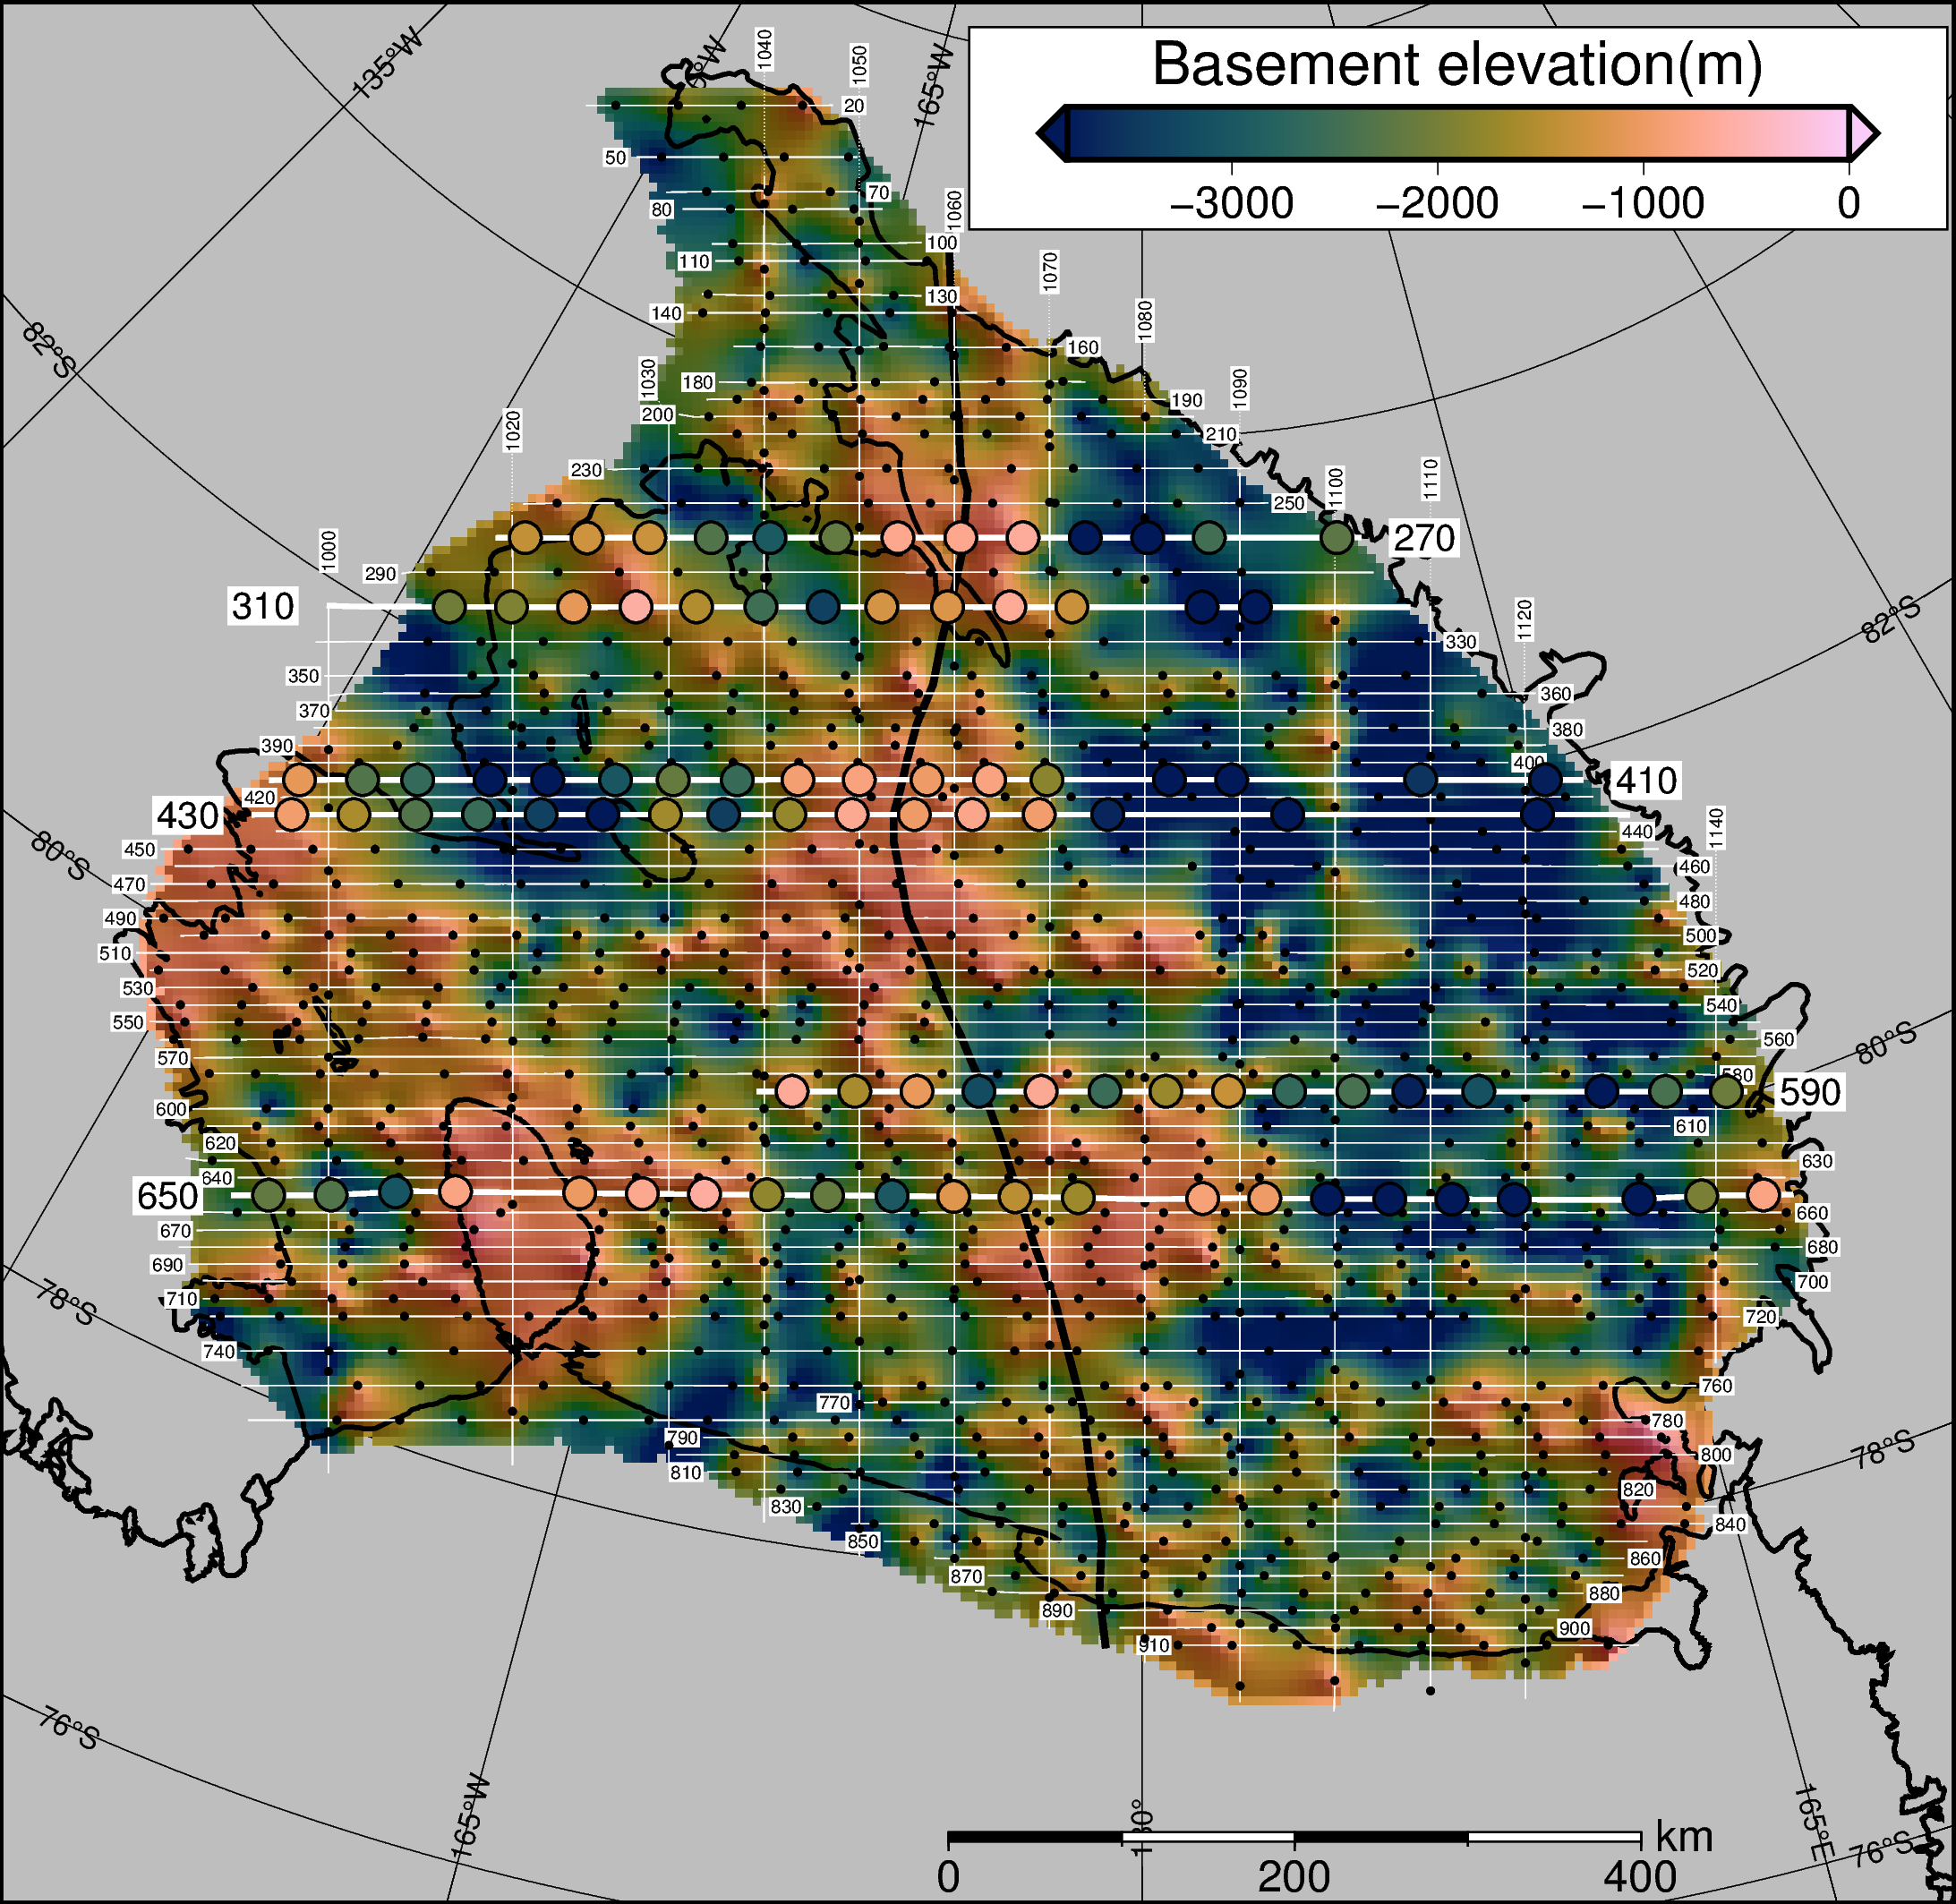

In [6]:
# make_grid(lines=(270,310,410,430,590,650))

## Save figure

In [55]:
# out='outputs/Fig_S4_unfiltered_basement.jpg'
# fig.savefig(out, dpi=200)

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.
